In [1]:
using Base.Threads
using BenchmarkTools
using Plots

In [20]:
N = 100_000
x = rand(N)
J = 100
L = 1
dx = L/(J-1)
d = zeros(Int64,J)


get_j (generic function with 1 method)

In [ ]:

function get_j(i, J, L, x)
    _, j = modf((x[i] / L * J + J) % J)
    j = floor(Int64, j) + 1
    return j
end


In [3]:
function get_d!(d,x,J,L)
    for i in 1:length(x)
        j = get_j(i, J, L, x)
        d[j] += 1
    end
end


get_d! (generic function with 1 method)

In [21]:
get_d!(d,x,J,L)

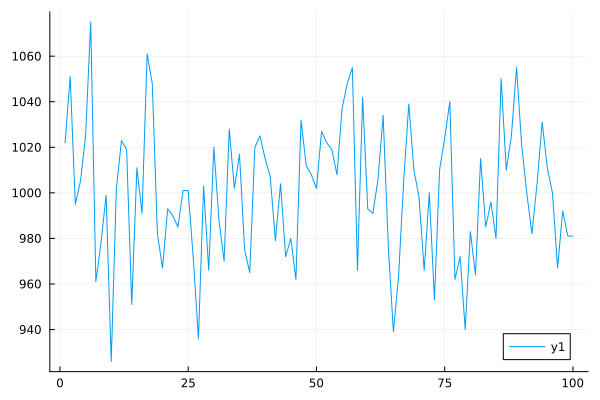

In [22]:
plot(d)

In [23]:
function get_d_threads!(d,x, J, L)
    Threads.@threads for i in 1:length(x)
        j = get_j(i, J, L, x)
        d[j] += 1
    end
end

get_d_threads! (generic function with 1 method)

In [24]:
dtf = zeros(Int64,J)

get_d_threads!(dtf,x, J, L)

dtf

100-element Vector{Int64}:
 1019
 1048
  988
 1004
 1023
 1069
  959
  976
  990
  921
    ⋮
  979
  999
 1028
 1008
  998
  961
  988
  977
  976

In [25]:
dtf === d

false

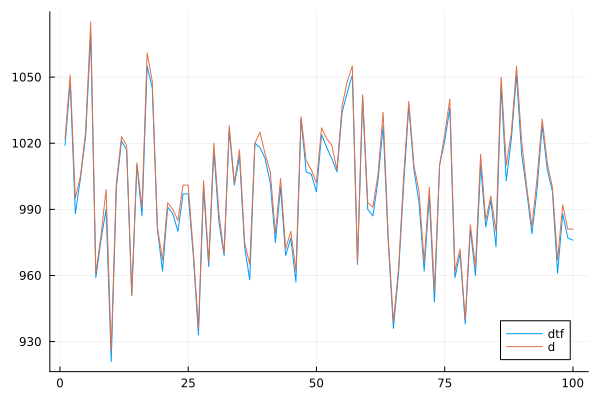

In [26]:
plot(dtf, label="dtf")
plot!(d, label="d")

In [27]:
function get_d_threads_good!(d,x, J, L)
    local_d = zeros(J, nthreads())
    @threads for i in 1:length(x)
        j = get_j(i, J, L, x)
        local_d[j,threadid()] += 1
    end
    d[:] = reduce(+, eachslice(local_d, dims=2));
end

get_d_threads_good! (generic function with 1 method)

In [28]:
dtg = zeros(Int64,J)
get_d_threads_good!(dtg,x, J, L)

100-element Vector{Float64}:
 1022.0
 1051.0
  995.0
 1005.0
 1025.0
 1075.0
  961.0
  978.0
  999.0
  926.0
    ⋮
  982.0
 1004.0
 1031.0
 1011.0
 1000.0
  967.0
  992.0
  981.0
  981.0

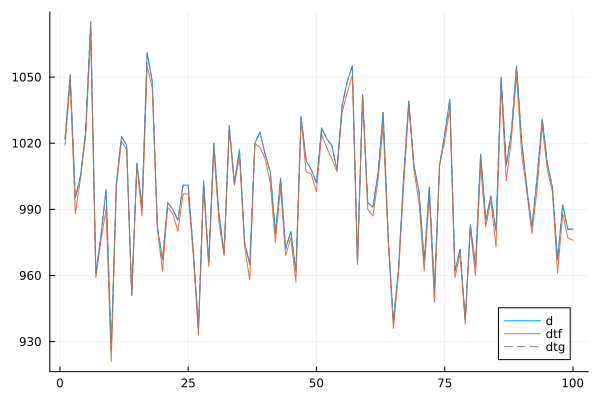

In [29]:
plot(d, label="d")
plot!(dtf, label="dtf")
plot!(dtg, label="dtg", ls=:dash, color="gray")

In [30]:
dtg - d

100-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

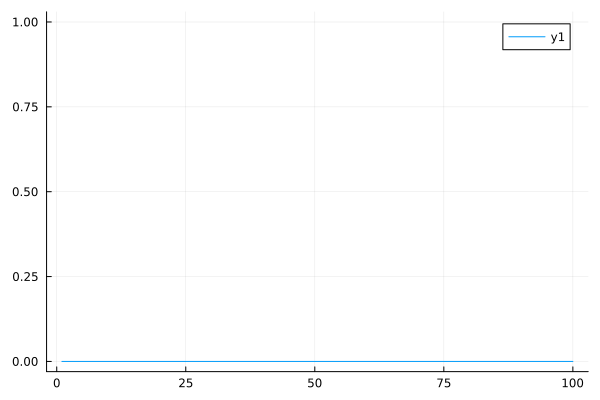

In [31]:
plot(d-dtg)

In [32]:
@btime get_d_threads_good!(dtg,$x, J, L)

  2.366 ms (15 allocations: 3.75 KiB)


100-element Vector{Float64}:
 1022.0
 1051.0
  995.0
 1005.0
 1025.0
 1075.0
  961.0
  978.0
  999.0
  926.0
    ⋮
  982.0
 1004.0
 1031.0
 1011.0
 1000.0
  967.0
  992.0
  981.0
  981.0

In [33]:
@btime get_d!(d,$x,J,L)

  4.330 ms (0 allocations: 0 bytes)
